# 4. Spatial and spectral matching between imaging data and IFS data cube using `piXedfit_spectrophotometric` -- Part II

<font size="4">In this step, we correct for the wavelength-dependant mismatch between the IFS spectra and the photometric SEDs on pixel level. This mismatch can be caused by at least two factors: systematics in the data processing (PSF matching, spatial resampling, reprojection, etc.) of the broadband imaging and IFS data and the uncertainty in the flux calibration of the IFS and imaging data. The correction can be performed using `piXedfit.piXedfit_spectrophotometric.match_specphoto` function. Basically, this function will perform simple SED fitting to the photometric SED of individual pixels to find a best-fit model spectrum for each pixel. A wavelength-dependent ratio (between the best-fit model spectrum and the IFS spectrum) is then fit with a third-order Legendre polynomial function to get smooth correction factor, which is then applied to correct the IFS spectra.</font>

In [1]:
import numpy as np
from astropy.io import fits
import os, sys
import matplotlib.pyplot as plt

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME)

%matplotlib inline

In [2]:
from piXedfit.piXedfit_spectrophotometric import match_imgifs_spectral

<font size="4"> The following calculation is rather heavy and time-consuming, depending on the number of pixels (that have spec+photo SEDs) and the number of cores used (nproc) in the calculation. It's recommended to run this calculation separately (from this jupyter notebook) on a multicores computer (or cluster). The computational time can be shorten by increasing the number of cores. A script for executing this function separately (on the terminal) is given in the directory: `script_match_imgifs_spectral.py`. </font>   

### Below is a copy of the script
specphoto_file = "specphoto_fluxmap_ngc309.fits"
name_saved_randmod = "ngc309_models.fits.gz"       # model SEDs generated before
name_out_fits = "corr_%s" % specphoto_file

match_imgifs_spectral(specphoto_file, nproc=20, name_out_fits=name_out_fits)

## 4.3. Check the result: spectrophotometric data cube

In [3]:
cube = fits.open("corr_specphoto_fluxmap_ngc309.fits")
cube.info()
header = cube[0].header
print (header)

Filename: corr_specphoto_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PHOTO_FLUX    1 PrimaryHDU      34   (131, 131, 12)   float64   
  1  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  2  WAVE          1 ImageHDU         7   (1901,)   float64   
  3  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1901)   float64   
  4  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  5  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  6  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  7  MOD_WAVE      1 ImageHDU         7   (1553,)   float64   
  8  MOD_FLUX      1 ImageHDU         9   (131, 131, 1553)   float64   
  9  CORR_FACTOR    1 ImageHDU         9   (131, 131, 1901)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / numbe

<font size="4"> Get the 3D data cubes </font>

In [4]:
photo_region = cube['PHOTO_REGION'].data
spec_region = cube['SPEC_REGION'].data
wave = cube['wave'].data
photo_flux = cube['PHOTO_FLUX'].data
photo_flux_err = cube['PHOTO_FLUXERR'].data
spec_flux = cube['SPEC_FLUX'].data
spec_flux_err = cube['SPEC_FLUXERR'].data
# get model: best-fit to photometric SED
mod_wave = cube['MOD_WAVE'].data
mod_flux = cube['MOD_FLUX'].data
corr_factor = cube['corr_factor'].data

# get unit
unit = header['unit']
cube.close()

<font size="4"> See coverages of Images and IFS

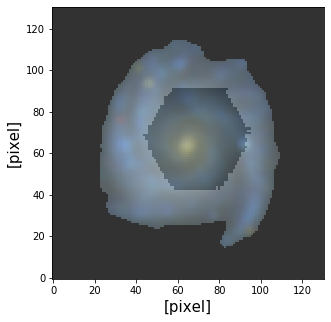

In [5]:
%matplotlib inline

from astropy.visualization import make_lupton_rgb

g = photo_flux[3]*10
r = photo_flux[4]*10
i = photo_flux[5]*10

rgb_default = make_lupton_rgb(i, r, g)

### plot photo and spec+photo regio
fig1 = plt.figure(figsize=(5,5))
f1 = plt.subplot()
plt.xlabel('[pixel]', fontsize=15)
plt.ylabel('[pixel]', fontsize=15)

plt.imshow(rgb_default, origin='lower', alpha=1.0)
plt.imshow(spec_region, origin='lower', cmap='Greys', alpha=0.2)

<font size="4"> **Check SEDs of some pixels** </font>

In [6]:
# get photometric and spectroscopic SEDs of pixels:
#transpose (band,y,x) => (y,x,band):
pix_photo_SED = np.transpose(photo_flux, axes=(1, 2, 0))*unit           ## erg/s/cm^2/A
pix_photo_SED_err = np.transpose(photo_flux_err, axes=(1, 2, 0))*unit

#transpose (wavelength,y,x) => (y,x,wavelength):
pix_spec_SED = np.transpose(spec_flux, axes=(1, 2, 0))*unit
pix_spec_SED_err = np.transpose(spec_flux_err, axes=(1, 2, 0))*unit
pix_mod_spec_SED = np.transpose(mod_flux, axes=(1, 2, 0))*unit
pix_corr_factor = np.transpose(corr_factor, axes=(1, 2, 0))

In [7]:
# get filters
nbands = header['nfilters']
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(header[str_temp])

# get central wavelength of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

<font size="4"> Plot SEDs of some pixels in the central region. The black spectra are the best-fit model to photometric SED that was used as reference in correcting for the photometry vs. spectroscopy mismatch. </font>

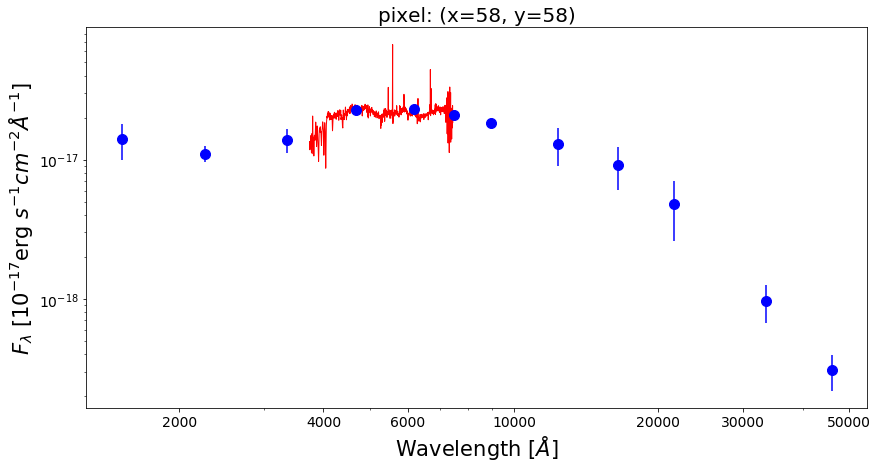

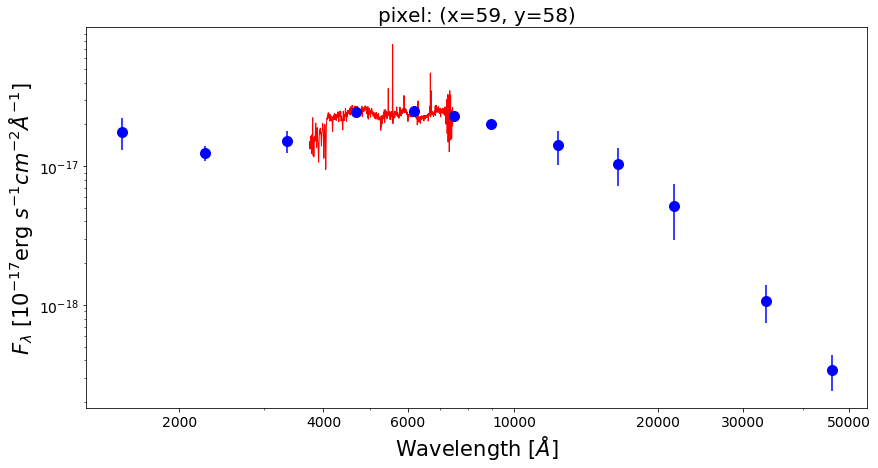

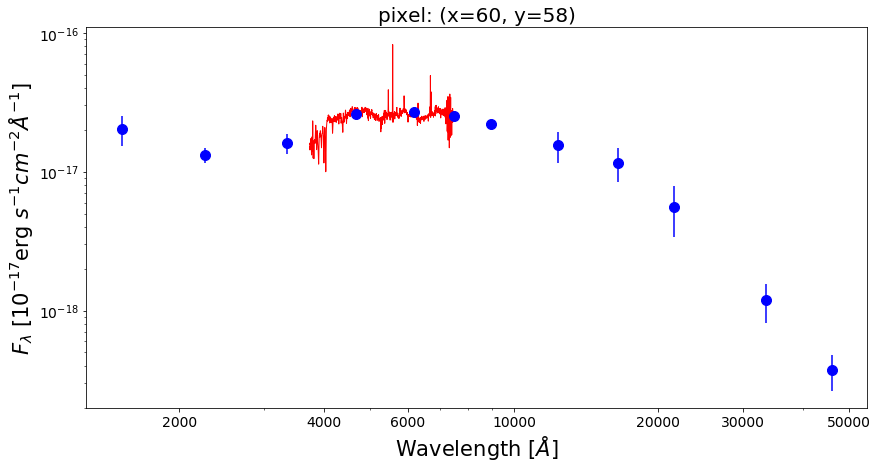

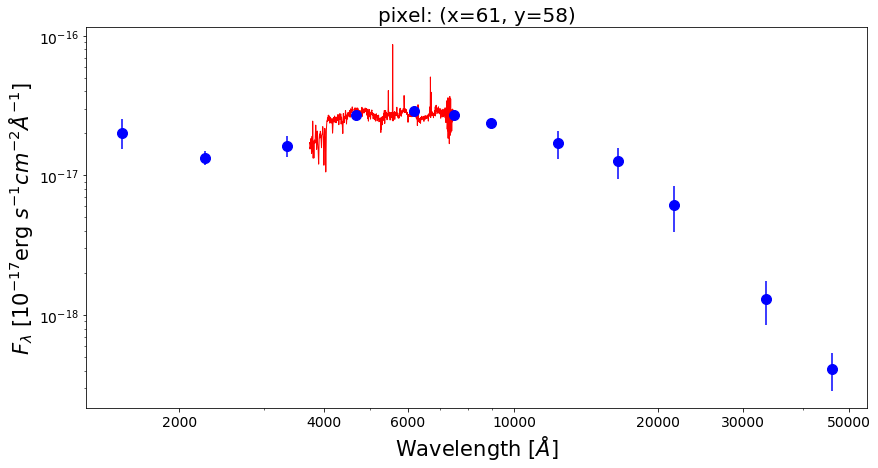

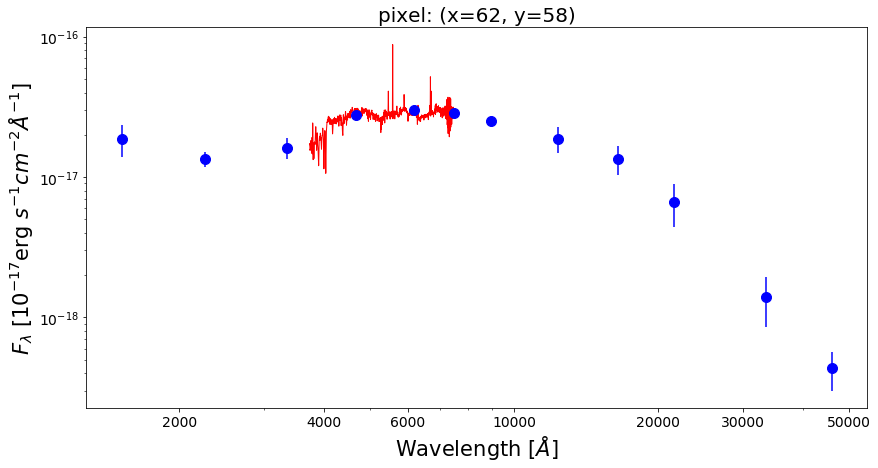

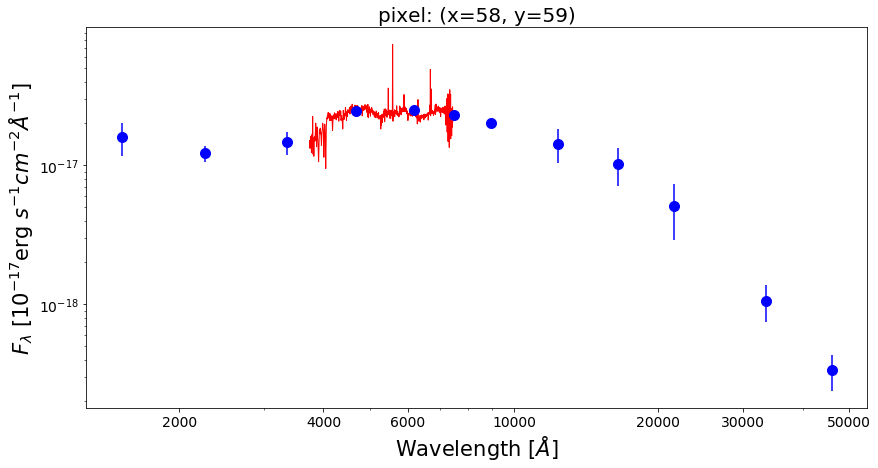

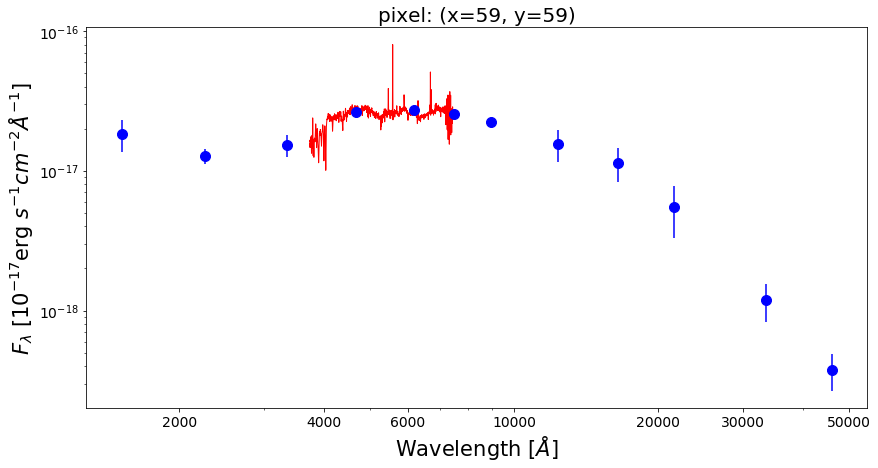

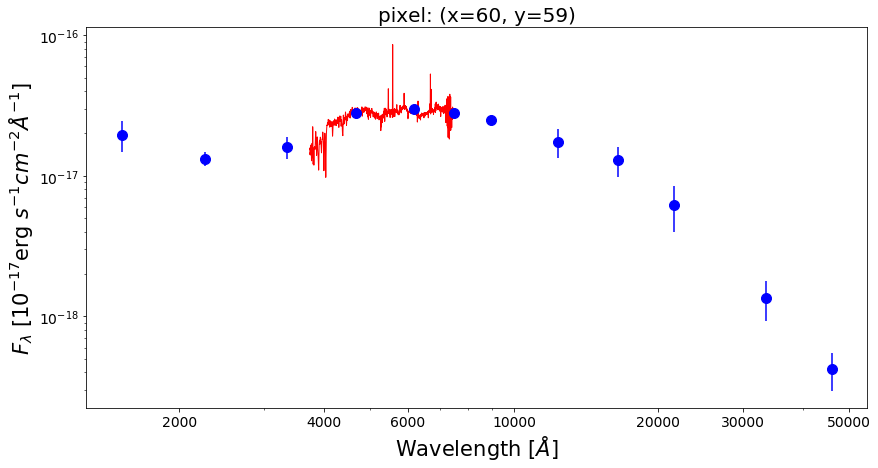

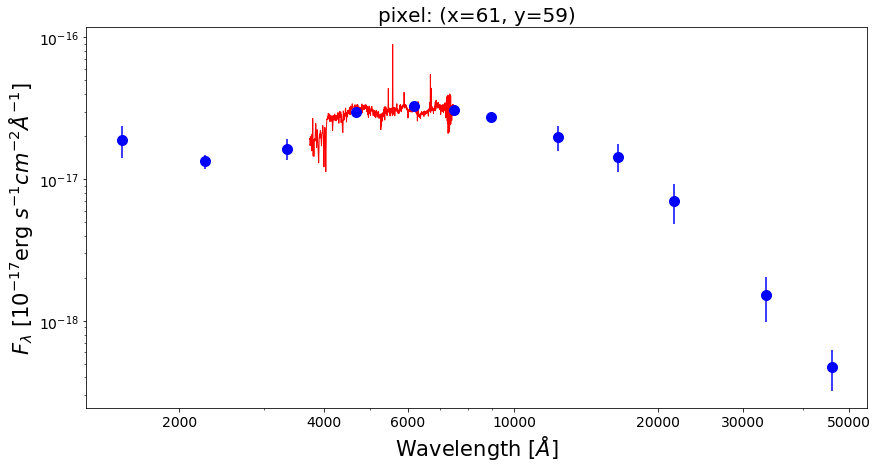

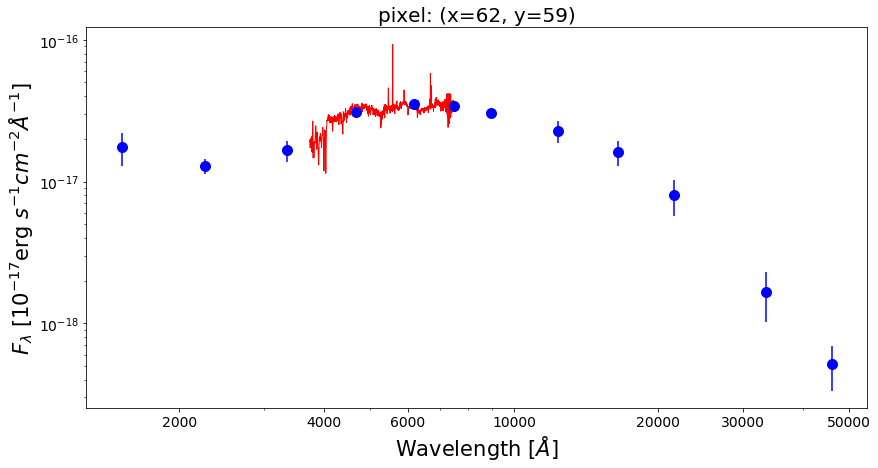

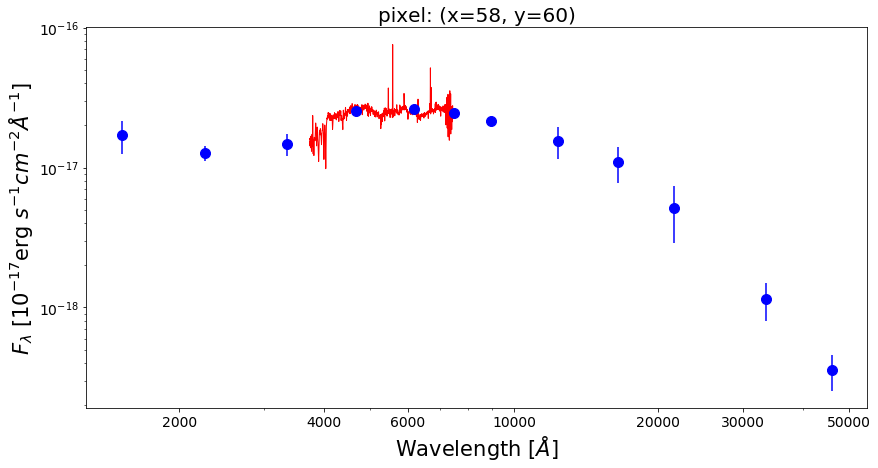

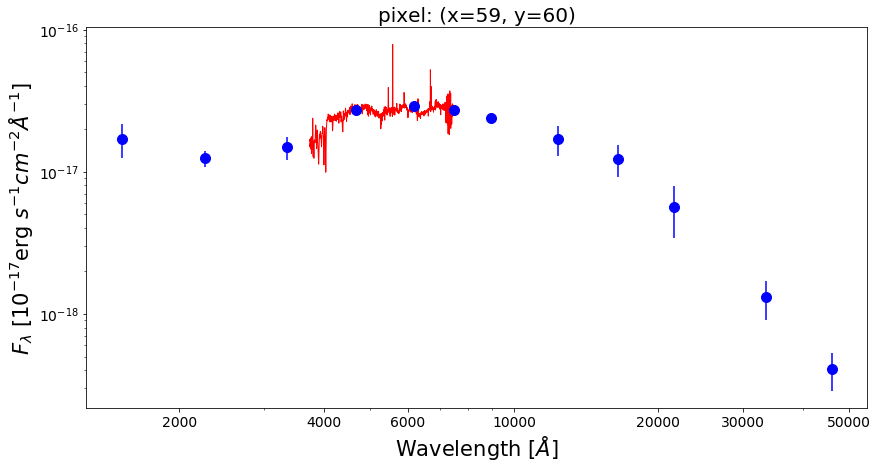

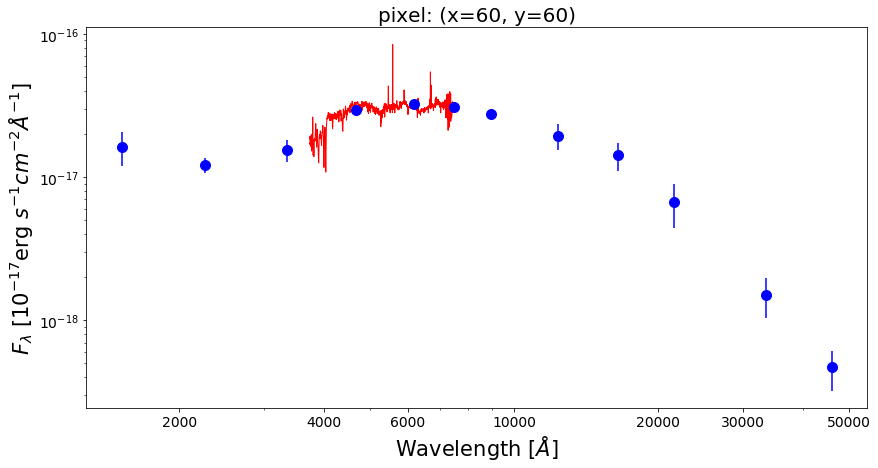

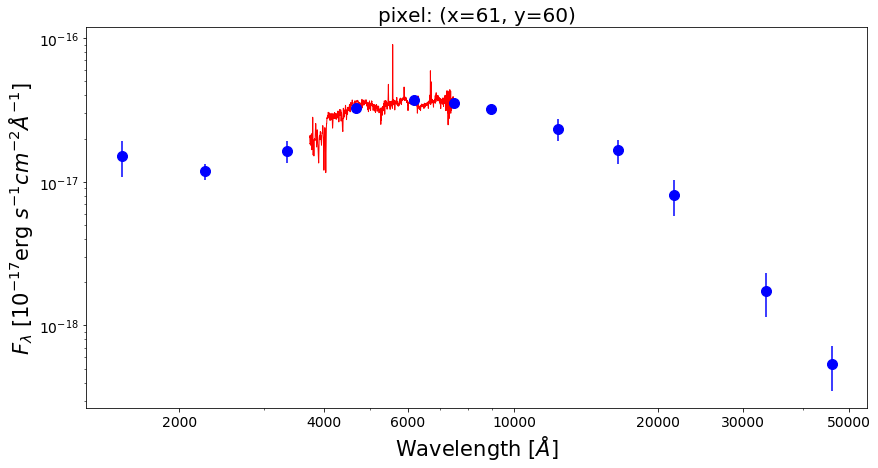

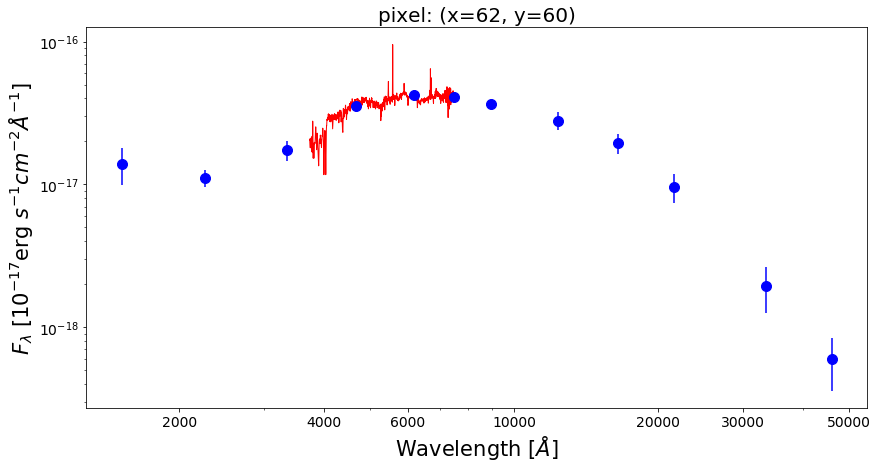

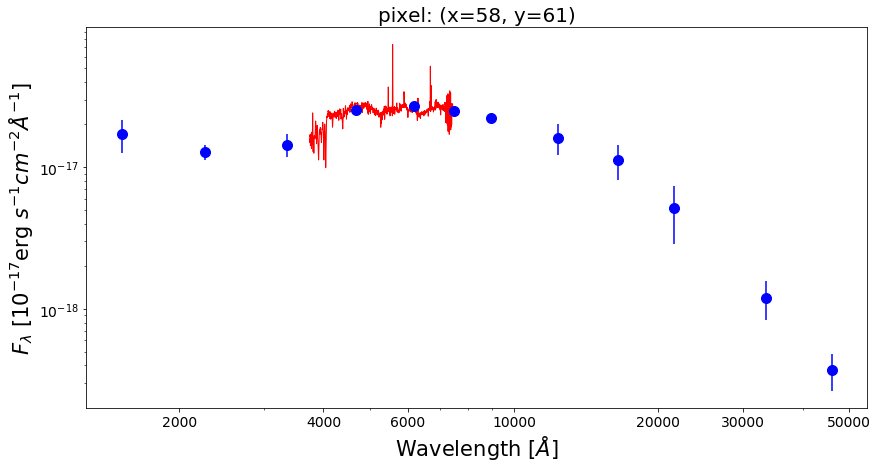

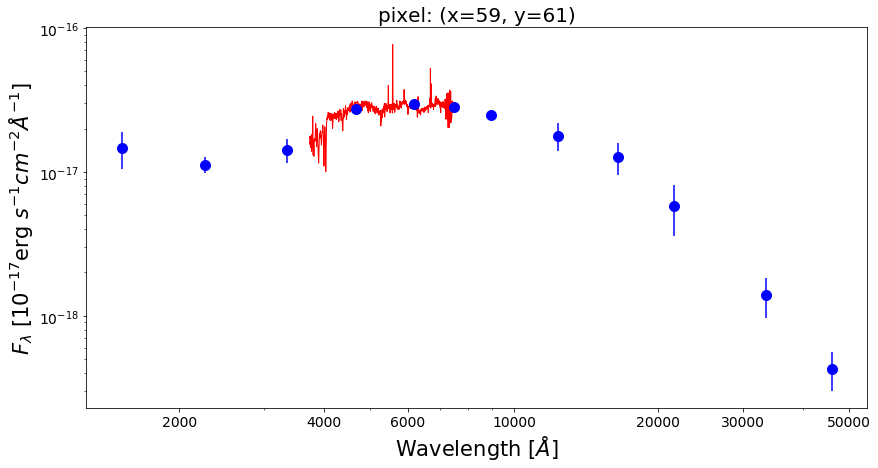

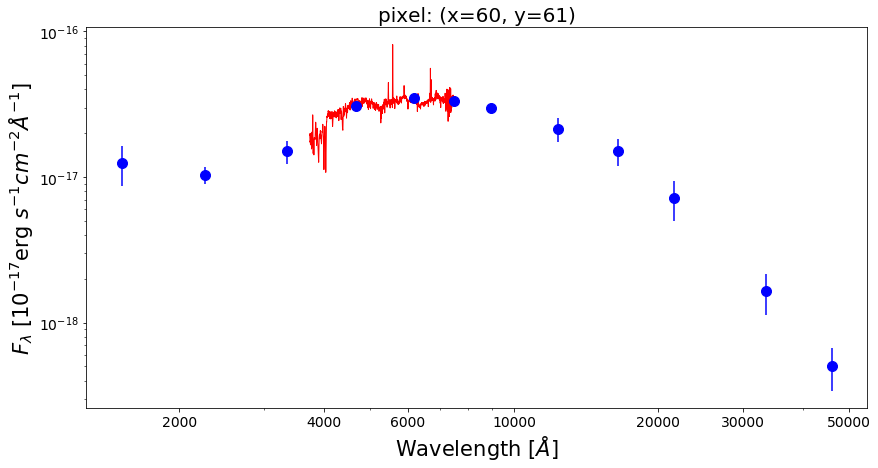

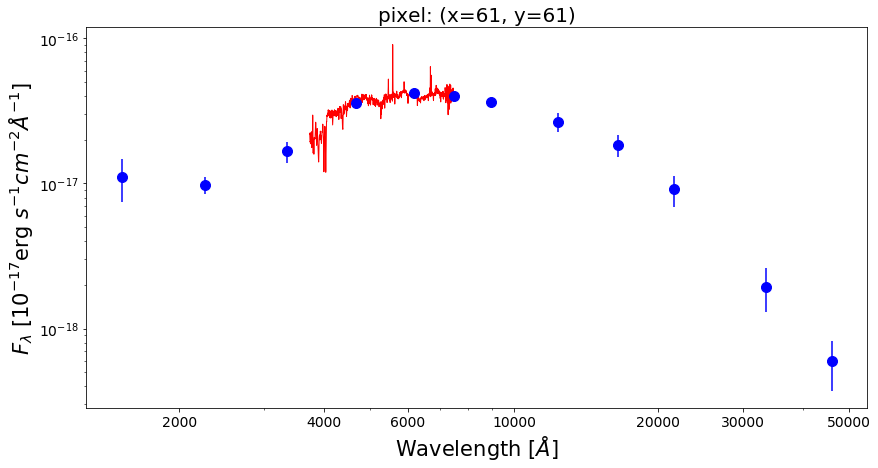

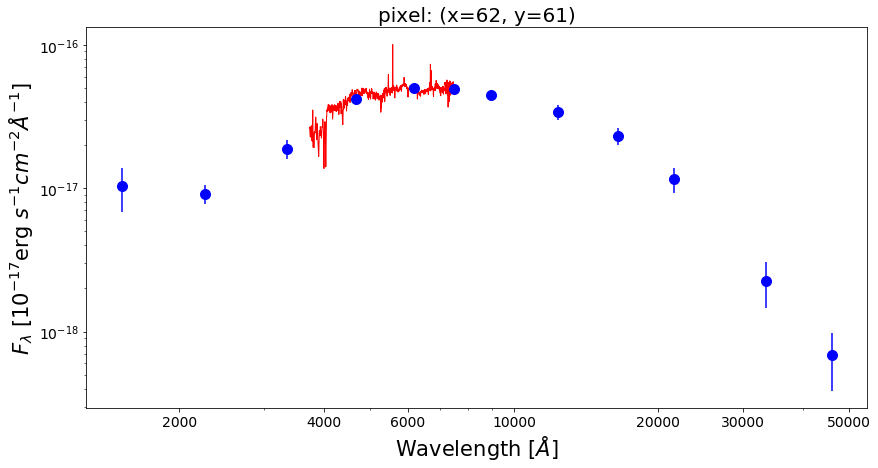

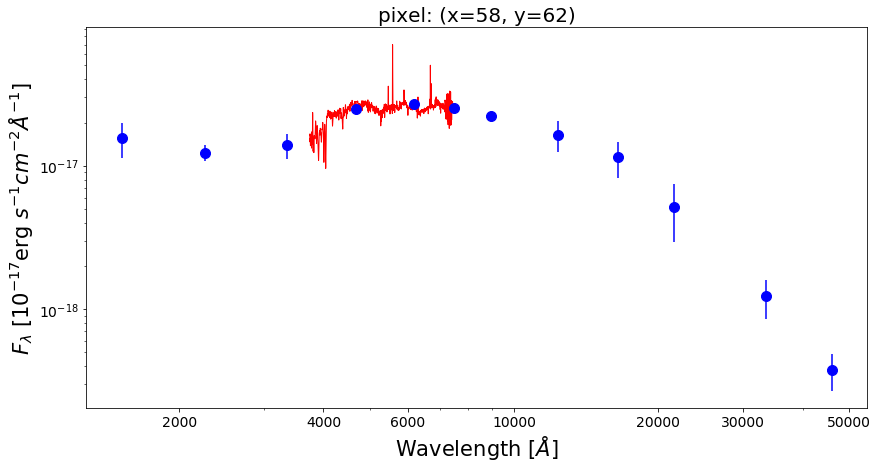

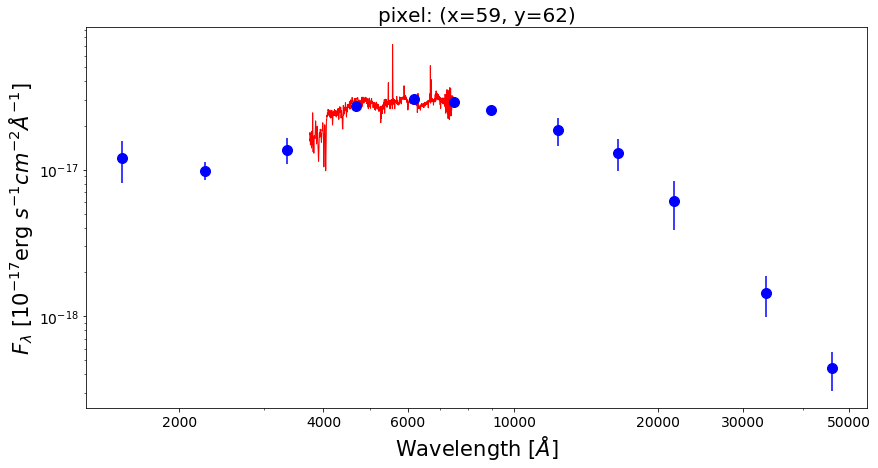

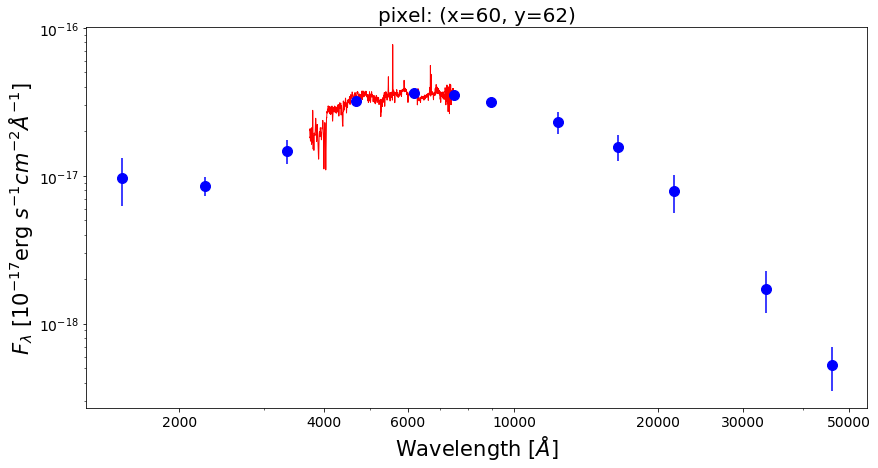

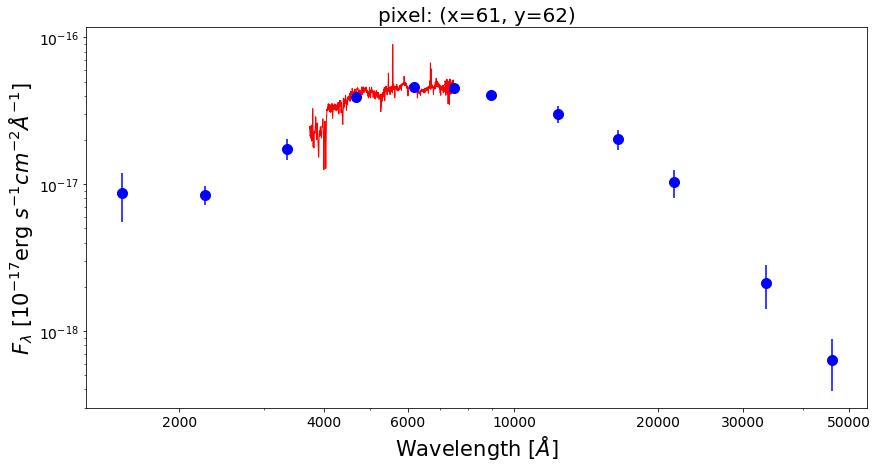

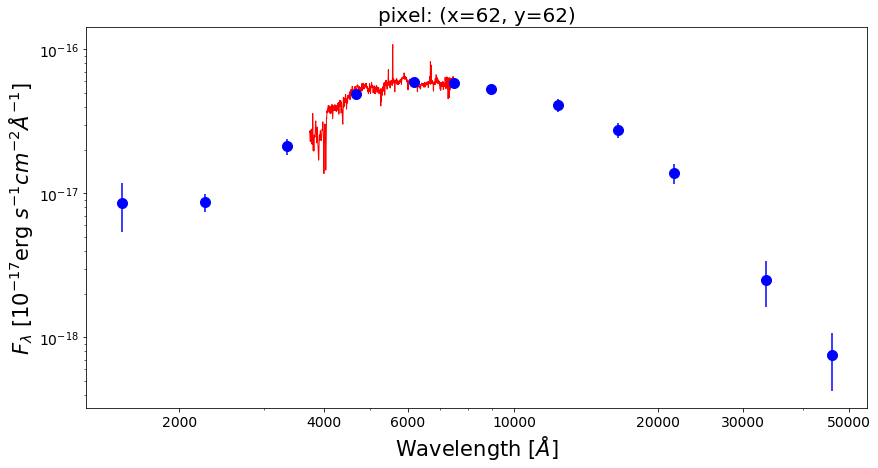

In [20]:
from matplotlib.ticker import ScalarFormatter

# Optional: cut the spectra around the edge to exclude those commonly uncertain fluxes
nwaves = len(wave)

for yy in range(58,63):
    for xx in range(58,63): 
        if spec_region[yy][xx]==1:
            fig1 = plt.figure(figsize=(14,7))
            f1 = plt.subplot()   
            plt.title("pixel: (x=%d, y=%d)" % (xx,yy), fontsize=20)
            f1.set_yscale('log')
            f1.set_xscale('log')
            plt.setp(f1.get_yticklabels(), fontsize=14)
            plt.setp(f1.get_xticklabels(), fontsize=14)
            plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
            plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
            xticks = [2000,4000,6000,10000,20000,30000,50000]
            plt.xticks(xticks)
            #plt.xlim(3000,10000)
            #plt.ylim(1.0e-19,8e-16)
            for axis in [f1.xaxis]:
                axis.set_major_formatter(ScalarFormatter())
            
            # Optional: cut the spectra around the edge to exclude 
            # those commonly uncertain fluxes
            plt.plot(wave[20:nwaves-20], pix_spec_SED[yy][xx][20:nwaves-20], lw=1.0, color='red')
            plt.errorbar(photo_wave, pix_photo_SED[yy][xx], yerr=pix_photo_SED_err[yy][xx], 
                         markersize=10,color='blue', fmt='o')
            
            #plt.plot(mod_wave, pix_mod_spec_SED[yy][xx], lw=1.0, color='black')
            #plt.plot(wave, pix_corr_factor[yy][xx]*unit, lw=2, color='gray')